In [1]:
# What we aim to do here is numerically simulate a package of gfp molecule signal linked to a stochastically-
# varying promoter state in a gene. The idea is that if we tweak our parameters in our numerical model, we 
# can then fit the numerical model to our actual fly embryo data, in order to be able to say something about
# how this gene is turned on.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import gfp_signal
from telegraph import exponential

In [4]:
# Simulate a transcription promoter using my exponentially-distributed wait time telegraph signal and
# my simulation of GFP agglomeration following an "ON" or "OFF" prompt

# make the system more likely to linger in off stage: choose k_off to be less than k_on such that
#                       mean_off = 1.0 / k_off   >    1.0 / k_on
k_on = 0.03
k_off = 0.03  
duration = 555 # seconds
stepsize = 3   # seconds / step

tel = exponential(k_on, k_off, duration, stepsize)

promoter_sig = tel.signal

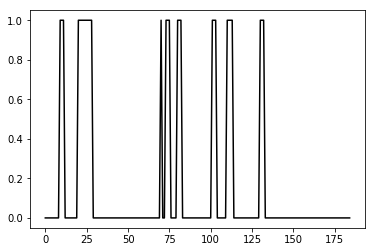

In [5]:
plt.plot(promoter_sig, color='k')

In [6]:
sum(promoter_sig) / len(promoter_sig)

0.15675675675675677

In [7]:
# Now add the numerically-simulated agglomeration of GFP stem-loops which generate the fluorescence signal we see
# parameters
sig = promoter_sig
k_gfp = 1./6       # gfp molecules / second
cts = 1000      # counts per gfp molecule
k_polII = 1     # how many polII's started per second
max_loops = 24  # max number of gfp loops that attach to each polII site

gfp = gfp_signal.gfp_signal(telegraph=sig, k_gfp=k_gfp, k_polII=k_polII, cts_per_gfp=cts, max_loops=max_loops, stepsize=3)

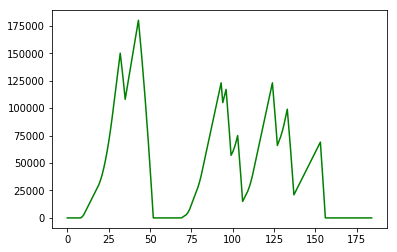

In [8]:
plt.plot(gfp.counts, color='g')

In [12]:
# Now let's simulate this ~80 times to create a package of traces we'd expect from actual data.
# Parameters:
k_on = 0.01
k_off = 0.03 
duration = 551   # seconds
stepsize = 3     # seconds / step

k_gfp = 1./6      # gfp chain elongation rate
cts = 1000       # counts per gfp molecule
k_polII = 1      # how many polII's started per second
max_loops = 24   # max number of gfp loops that attach to each polII site


num = 150           # number of traces in our simulated dataset
auto_traces = []    # empty list of autocorrelation arrays
tracelist = []      # empty list of traces 
corrected_traces = []     # corrected traces
max_list = []

for i in range(num):
    tel = exponential(k_on, k_off, duration, stepsize)  # create a new signal every time      
    gfp = gfp_signal.gfp_signal(telegraph=tel.signal, k_gfp=k_gfp, k_polII=k_polII, cts_per_gfp=cts, max_loops=max_loops, stepsize=3)
    
    trace = np.asarray(gfp.norm) 
    
    tracelist.append(trace)
    max_list.append(np.max(np.asarray(trace)))
    
# now do the trace calibration and compute the autocorrelation
# F(t) = I(t) / Io

I_o = np.mean(np.max(np.asarray(max_list)))

for trace in tracelist:
    
    calibrated_trace = trace / I_o
       
    corrected_trace = calibrated_trace - np.mean(calibrated_trace) # subtract mean fluorescence from each trace as in Desponds et al
    # (this should get rid of nucleus-to-nucleus variability)
    
    corrected_traces.append(corrected_trace)
    
    auto_trace = np.correlate(corrected_trace, corrected_trace, 'full')
    #auto_traces.append(auto_trace / (np.std(norm_trace) * np.std(norm_trace)))   # divide each auto trace by the standard deviation squared to normalize
    
    automax = np.max(auto_trace)
    if automax <= 0:
        automax = 1
    
    auto_traces.append(auto_trace)#/ np.max(auto_trace))   # divide each auto trace by its maximum to normalize to 1.
    

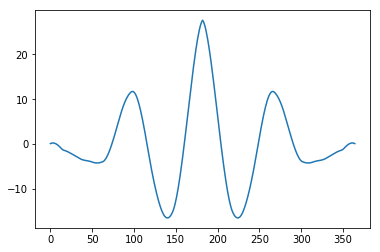

In [13]:
plt.plot(auto_traces[38])
plt.show()

In [1355]:
print("mean fluorescence of trace 8 = " + str(np.mean(traces[8])))

mean fluorescence of trace 8 = 134.40437158469945


In [75]:
# loop function that describes GFP MS2 loop aggregation
def loop_fn(maxloops, gfp_elong):
    return np.arange(1, maxloops+1, gfp_elong).astype(int)  

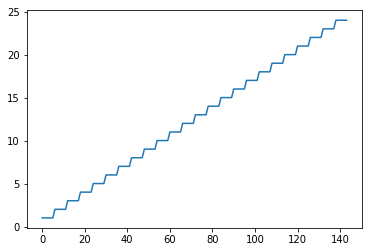

In [76]:
plt.plot(loop_fn(24,1./6))

In [1357]:
# define our average fluorescence function according to Desponds et al's analytic model such that we can fit for p_on
# P_on = <Fluorescence> / sum(loop function)
def avg_flr(trace, p_on):
    maxloops = 24
    gfp_elong = 1./6
    
    loop = loop_fn(maxloops, gfp_elong)    
    trace = np.asarray(trace)
    
    return p_on * np.sum(loop)

In [1358]:
# compute average fluorescence for each raw simulated trace
avg_flors = []
for i in traces:
    avg_flors.append(np.mean(i))
np.asarray(avg_flors);

In [1359]:
# give us an easy range to fit over
x = np.arange(len(avg_flors))

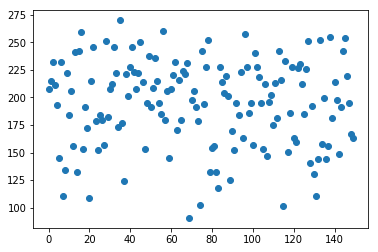

In [1360]:
plt.scatter(x, avg_flors)

In [1361]:
# do a multiple linear regression fitting for the constant parameter, p_on.
from scipy.optimize import curve_fit
popt_pon,_ = curve_fit(avg_flr, x, ydata=avg_flors)
print("Average fitted P_on for trace package = " + str(popt_pon))

Average fitted P_on for trace package = [0.10795365]


In [1362]:
f_avg = np.mean(avg_flors)   # calculate the square of the first moment

f_sqs = np.zeros(len(avg_flors))

for i in range(len(avg_flors)):
    f_sqs[i] = avg_flors[i]**2  

f_sq_avg = np.mean(f_sqs)        # calculate the second moment
var_f = -f_sq_avg + f_avg**2

In [1363]:
print("variance of steady state fluorescence signal = " + str(var_f))

variance of steady state fluorescence signal = -1540.1099101860818


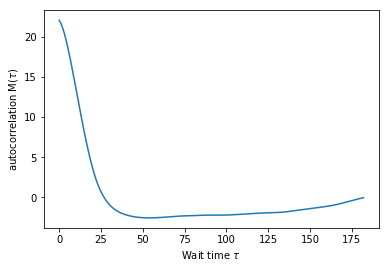

In [14]:
# Now compute the average correlation function from the set of 70.
# We see that the autocorrelation function appears as a decay curve
mean_auto_data = np.mean(auto_traces, axis = 0)
plt.plot((mean_auto_data[np.argmax(mean_auto_data):]))   # plot only half of the autocorrelation function (symmetric on both sides of max)


t = np.linspace(start=0,stop=100 )

plt.xlabel(r'Wait time $\tau$')
plt.ylabel(r'autocorrelation M($\tau$)')
plt.show()

In [29]:
# create a routine that bootstraps a set of data arrays according to Coulon & Lardon (2016)

cutoff = np.argmax(mean_auto_data)    # take only the right half of autocorrelation fns, based on our og dataset's max
corrected_traces = np.asarray(corrected_traces)   # convert to a numpy array to play with indices
n_traces = len(tracelist)                # number of traces in our dataset
n_trials = 1000                       # how many times we wish to compute the bootstrap loop
trace_indx = np.arange(n_traces)      # the index range of the list of traces
auto_averages = []                    # list of averaged autocorrelation functions (should be n_trials long)


# sample randomly, with replacement, a new set of n_traces 10,000 times
for i in range(n_trials):
    
    # from our list of traces, sample radomly the trace_index of these datum in the list
    random_indx = np.random.choice(trace_indx, size=n_traces, replace=True)  
    
    # then use this array of indices to create our random package of traces
    sample_set = corrected_traces[random_indx]
    auto_list = []
    
    # next compute the autocorrelation function from this package of traces
    for sample in sample_set:
        aut = np.correlate(sample, sample, 'full')
        #auto_list.append(aut / (np.std(sample) * np.std(sample)))   # normalize each correlation for easy fitting later
    
        auto_list.append(aut) #/ np.max(aut))   # normalize each autocorrelation to 1

    
    auto_mu = np.mean(auto_list, axis=0)      # now average together the autocorrelation functions from the list    
    auto_averages.append(auto_mu[cutoff:])    # add the right half of the average to the list of average autocorrelation functions


In [30]:
auto_averages = np.asarray(auto_averages)

In [31]:
# now let's compute the standard deviations of the set of 10000 autocorrelation functions. This is the STANDARD ERROR
# on our dataset
# compute at each time step (tau):
std_dev_arr = np.std(auto_averages, axis=0)

In [32]:
len(std_dev_arr)

183

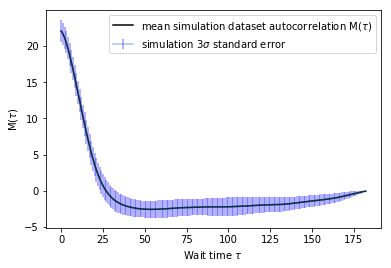

<Figure size 432x288 with 0 Axes>

In [33]:
tau = np.arange(len(mean_auto_data[cutoff:]))   # tau array to plot against

plt.errorbar(x=tau, y=mean_auto_data[cutoff:], yerr=(std_dev_arr*3, std_dev_arr*3), ecolor='b', alpha=0.4, label = r'simulation $3\sigma$ standard error')  

# show the mean of our original dataset in red
plt.plot(tau, mean_auto_data[cutoff:], color='k', label = r'mean simulation dataset autocorrelation M($\tau$)')
plt.legend()
plt.xlabel(r'Wait time $\tau$')
plt.ylabel(r'M($\tau$)')
plt.show()

plt.savefig('/Users/tmakinen/Documents/plots/errorbar.png', dpi='figure', bbox_inches='tight', overwrite=True)

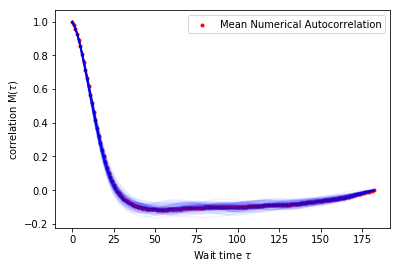

In [34]:
for i in auto_averages[::10]:
    plt.plot(i/np.max(i), color='b', alpha=0.05)   # plot a bunch of our traces to see error zones
    
plt.scatter(tau, mean_auto_data[cutoff:] /np.max(mean_auto_data[cutoff:]), marker='.', color='r', label = 'Mean Numerical Autocorrelation')   # show the mean of our original dataset in red
plt.legend()
plt.xlabel(r'Wait time $\tau$')
plt.ylabel(r'correlation M($\tau$)')
plt.show()

In [68]:
""""
Autocorrelation function analysis using Despond et al's two-state model
parameters:
    p_on: probability that system is in an on state, p_on = k_on / k_off + k_on
    k_on: given as 1/mu for exponential distribution of ON wait times
    k_off: 1/mu for exponential distribution of OFF wait times
    k_gfp: gfp loop agglomeration rate such that L(t) = k_gfp*t, L(t) !> maxloops
    maxloops: max number of gfp loops allowed in chain
    """


def autocorr(t, chartime):  # take in parameters and t (index of signal data array)
    
    #k_on = pars[0]
    #k_off = pars[1]
    duration = 551
    stepsize = 3   # seconds / step

    k_gfp = 3       # gfp molecules / second
    cts = 1000      # counts per gfp molecule
    k_polII = 1     # how many polII's started per second
    maxloops = 24  # max number of gfp loops that attach to each polII site
    
    var_f = 1540.69413784294  # calculated above
    v_elg = 1/6     # elongation rate of GFP MS2 loop chain
    v_elg_step = v_elg * stepsize  # elongation rate by timestep
    r=maxloops      # index
    
    # loop function that describes GFP MS2 loop aggregation
    loop = np.arange(1, maxloops+1, v_elg_step).astype(int)  
    
    # write analytic autocorrelation function according to Desponds et al:    
    # chartime is defined as k_on + k_off
    
    delta = 1 - chartime
    
    #frac = 1 / ((1/k_on) + (1/k_off))
        
    p_on = 0.108
    p_off = (1-p_on)
    
       
    # write a for loop to do the double sums:
    sm = 0
    test = 0
    for i in np.arange(1,r+1):
        for j in np.arange(1,r+1):
            sm += p_on*p_off*(loop[i] * loop[j] * np.exp((delta-1)*np.abs(t - j + i)))
                        
    Cr = sm #/ np.max(sm)
    #return Cr   # normalize to 1
    
    # add in the finite trace correction for the Ornstein-Uhlenbeck process
   # k = duration // stepsize // 2    # length of our simulated time traces (steady state duration)
    
    k = len(Cr)
    
    sm1 = 0
    
    for i in range(1, k-1):
        sm1 += 2*(k - i)*Cr[i]
        
    sm2 = 0
    sm3 = 0
    Co = Cr[0]
    
    for i in range(1, r-1):
        sm2 += 2*(r-k)*Cr[i]
        
    for m in range(1, k-1):
        sm3 += Cr[m] * (np.min(np.asarray([m+r, k])) - np.max(np.asarray([r, m])))
    
    #corrected =    (1/var_f) * ((Cr + (1/k) * ((1/k) - (2./(k-r))) * (k*Co + sm1))  + ((2/(k*(k-r))) * (r*Co + sm2 + sm3)))
    corrected = (1/var_f)*((Cr + (1/k) * ((1/k) - (2./(k-r))) * (k*Co + sm1)) + 1)
    return  corrected  #/ corrected[1]

In [69]:
len(t)

183

183

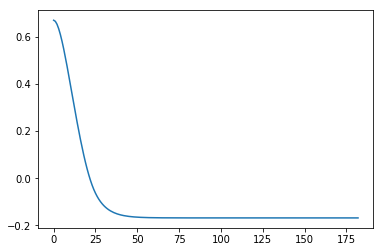

In [70]:
c = autocorr(t,0.14)
plt.plot(t, c)

len(c)

In [71]:
dat = mean_auto_data[cutoff:]
t = np.arange(len(dat))

In [72]:
from scipy.optimize import curve_fit

popt,pcov = curve_fit(autocorr, t, dat/(np.max(dat)))

popt

C:\Users\tmakinen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in multiply
C:\Users\tmakinen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in double_scalars
C:\Users\tmakinen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in add


array([0.15427501])

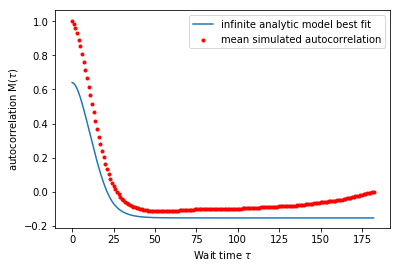

In [73]:
#plt.plot(tau, mean_auto_data[cutoff:])
plt.plot(t, autocorr(t, popt[0]), label='infinite analytic model best fit')
plt.scatter(t,dat/np.max(dat), marker='.', color='r', label = 'mean simulated autocorrelation')   # show the mean of our original dataset in red
plt.legend()
plt.xlabel(r'Wait time $\tau$')
plt.ylabel(r'autocorrelation M($\tau$)')
plt.show()

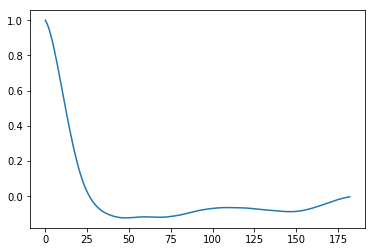

In [1377]:
plt.plot(dat)